# mto adult summary indices – causalpfn vs kling-liebman-katz

_pull table 2 numbers straight from kling/liebman/katz (w11577.pdf), rerun causalpfn on the adult cell-level and pseudo-individual files, and line up the effects. includes a quick uplift/qini peek on the adult overall index._

In [1]:
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdfplumber
import torch
from causalpfn import ATEEstimator, CATEEstimator
import causalpfn.causal_estimator as ce
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder

# keep mac runs stable
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "1")
os.environ.setdefault("VECLIB_MAXIMUM_THREADS", "1")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "1")
torch.set_num_threads(1)
torch.set_num_interop_threads(1)

MTO_DIR = Path("/Users/richardguo/csc494-spatialpfn/economics/mto")
PATH_CELLS = MTO_DIR / "mto_aer_ad_puf_cells_20131025.dta"
PATH_IND = MTO_DIR / "mto_aer_ad_puf_pseudo_20131025.dta"
PDF_PATH = MTO_DIR / "w11577.pdf"
RESULTS_DIR = MTO_DIR / "results"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
OUT_CSV = RESULTS_DIR / "kling_replication_causalpfn_notebook.csv"
DEVICE = "cpu"

# adult indices
Y_CELL = ["mn_f_all_idx_fix_z_ad", "mn_f_ec_idx_z_ad", "mn_f_mh_idx_z_ad", "mn_f_ph_idx_fix_z_ad"]
Y_PSEUDO = ["ps_f_all_idx_fix_z_ad", "ps_f_ec_idx_z_ad", "ps_f_mh_idx_z_ad", "ps_f_ph_idx_fix_z_ad"]
CONTRASTS = ["exp_vs_control", "s8_vs_control", "any_voucher_vs_control"]
DOMAIN_BY_Y = {
    "mn_f_all_idx_fix_z_ad": "overall",
    "mn_f_ec_idx_z_ad": "economic",
    "mn_f_mh_idx_z_ad": "mental_health",
    "mn_f_ph_idx_fix_z_ad": "physical_health",
    "ps_f_all_idx_fix_z_ad": "overall",
    "ps_f_ec_idx_z_ad": "economic",
    "ps_f_mh_idx_z_ad": "mental_health",
    "ps_f_ph_idx_fix_z_ad": "physical_health",
}

# patch causalpfn weak learner so small patches do not collapse

def _safe_train_weak_learner(self, X, t, y):
    self.t_transformer = OneHotEncoder(sparse_output=False, categories="auto", drop="first")
    T = self.t_transformer.fit_transform(t.reshape(-1, 1))
    self._d_t = (T.shape[1],)
    feat_arr = np.concatenate((X, 1 - np.sum(T, axis=1).reshape(-1, 1), T), axis=1)
    min_leaf = max(1, int(X.shape[0] / 100))
    self.stratifier = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=6,
        min_samples_leaf=min_leaf,
        random_state=111,
    )
    self.stratifier.fit(feat_arr, y)


ce.CausalEstimator._train_weak_learner = _safe_train_weak_learner


/Users/richardguo/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# scrape kling/liebman/katz table 2 adults directly from the pdf
import re

def parse_table2(pdf_path: Path) -> pd.DataFrame:
    with pdfplumber.open(pdf_path) as pdf:
        page_text = None
        for page in pdf.pages:
            txt = page.extract_text() or ""
            if "TABLE 2. MEAN EFFECT SIZES" in txt:
                page_text = txt
                break
    if not page_text:
        raise RuntimeError("table 2 page not found")
    lines = [ln.strip() for ln in page_text.splitlines() if ln.strip()]
    combined = " ".join(lines)
    labels = {
        "economic": "Economic",
        "physical_health": "Absence of physical",
        "mental_health": "Absence of mental",
        "overall": "Overall",
    }
    rows: list[dict] = []
    for domain, label in labels.items():
        pat = rf"{label}\s+([-.0-9\*]+)\s+([-.0-9\*]+).*?\(([-.0-9]+)\)\s+\(([-.0-9]+)\)"
        m = re.search(pat, combined, flags=re.IGNORECASE | re.DOTALL)
        if not m:
            print(f"no match for {domain}")
            continue
        exp_eff = float(m.group(1).replace("*", ""))
        s8_eff = float(m.group(2).replace("*", ""))
        exp_se = float(m.group(3))
        s8_se = float(m.group(4))
        rows.append({
            "domain": domain,
            "contrast": "exp_vs_control",
            "itt": exp_eff,
            "se": exp_se,
        })
        rows.append({
            "domain": domain,
            "contrast": "s8_vs_control",
            "itt": s8_eff,
            "se": s8_se,
        })
    return pd.DataFrame(rows)

bench_df = parse_table2(PDF_PATH)
bench_df


,domain,contrast,itt,se
0,economic,exp_vs_control,0.017,0.031
1,economic,s8_vs_control,0.037,0.033
2,physical_health,exp_vs_control,0.012,0.024
3,physical_health,s8_vs_control,0.019,0.026
4,mental_health,exp_vs_control,0.079,0.030
5,mental_health,s8_vs_control,0.029,0.033
6,overall,exp_vs_control,0.036,0.020
7,overall,s8_vs_control,0.028,0.022


In [3]:
# load cell-level adult indices and pseudo-individual file
df_cells = pd.read_stata(PATH_CELLS)
df_pseudo = pd.read_stata(PATH_IND)
print(df_cells.shape, df_pseudo.shape)


(81, 193) (3273, 74)


In [4]:
# helpers
def set_all_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


def to_binary01(series: pd.Series) -> pd.Series:
    if str(series.dtype).startswith("category"):
        series = series.astype(str)
    if np.issubdtype(series.dtype, np.number):
        return pd.to_numeric(series, errors="coerce").astype(float)
    s_str = series.astype(str).str.strip()
    leading = s_str.str.extract(r"^([01])\s*=")[0]
    leading2 = s_str.where(s_str.isin(["0", "1"]), np.nan)
    out = leading.fillna(leading2)
    return pd.to_numeric(out, errors="coerce").astype(float)


def build_t_and_keep(df: pd.DataFrame, contrast: str):
    exp = to_binary01(df["ra_grp_exp"])
    s8 = to_binary01(df["ra_grp_s8"])
    ctl = to_binary01(df["ra_grp_control"])
    if contrast == "any_voucher_vs_control":
        keep = ((exp == 1) | (s8 == 1) | (ctl == 1))
        t = ((exp == 1) | (s8 == 1)).astype(float)
    elif contrast == "exp_vs_control":
        keep = ((exp == 1) | (ctl == 1))
        t = (exp == 1).astype(float)
    elif contrast == "s8_vs_control":
        keep = ((s8 == 1) | (ctl == 1))
        t = (s8 == 1).astype(float)
    else:
        raise ValueError(f"unknown contrast {contrast}")
    return t.to_numpy().astype(np.float32), keep.to_numpy().astype(bool)


def pick_x_baseline(df: pd.DataFrame, y_col: str) -> np.ndarray:
    drop = {"ra_group", y_col}
    x_cols: list[str] = []
    for c in df.columns:
        if c in drop:
            continue
        if c.startswith("mn_x_") or c.startswith("ps_x_") or c.startswith("x_f_site_"):
            x_cols.append(c)
    if "ra_site" in df.columns and "ra_site" not in drop:
        x_cols.append("ra_site")
    X_df = df[x_cols].copy()
    cat_cols = [c for c in X_df.columns if X_df[c].dtype == "object" or str(X_df[c].dtype).startswith("category")]
    if cat_cols:
        X_df = pd.get_dummies(X_df, columns=cat_cols, drop_first=True)
    for c in X_df.columns:
        if X_df[c].isna().any():
            if np.issubdtype(X_df[c].dtype, np.number):
                X_df[c] = X_df[c].fillna(X_df[c].median())
            else:
                X_df[c] = X_df[c].fillna("MISSING")
    return X_df.astype(np.float32).to_numpy()


def standardize(X: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, keepdims=True)
    sd = np.where(sd < eps, 1.0, sd)
    return (X - mu) / sd


def ate_diff_in_means(Y: np.ndarray, T: np.ndarray) -> float:
    t1 = (T == 1)
    t0 = (T == 0)
    if t1.sum() == 0 or t0.sum() == 0:
        return float("nan")
    return float(Y[t1].mean() - Y[t0].mean())


def qini_uplift_curve(T: np.ndarray, Y: np.ndarray, scores: np.ndarray) -> pd.DataFrame:
    order = np.argsort(-scores)
    T = T[order]
    Y = Y[order]
    scores = scores[order]
    cum_treat = np.cumsum(T)
    cum_ctrl = np.cumsum(1 - T)
    cum_out_treat = np.cumsum(Y * T)
    cum_out_ctrl = np.cumsum(Y * (1 - T))
    with np.errstate(divide="ignore", invalid="ignore"):
        uplift = (cum_out_treat / np.maximum(cum_treat, 1e-9)) - (
            cum_out_ctrl / np.maximum(cum_ctrl, 1e-9)
        )
        qini = cum_out_treat - cum_out_ctrl * (cum_treat / np.maximum(cum_ctrl, 1e-9))
    frac = np.arange(1, len(T) + 1) / len(T)
    return pd.DataFrame({"fraction": frac, "uplift": uplift, "qini": qini, "score": scores})


In [5]:
# run causalpfn across adult indices (cells + pseudo)
rows: list[dict] = []
qini_store: dict[tuple[str, str, str], pd.DataFrame] = {}


def run_level(df: pd.DataFrame, y_cols: list[str], level: str):
    for y_col in y_cols:
        if y_col not in df.columns:
            continue
        for contrast in CONTRASTS:
            T_all, keep = build_t_and_keep(df, contrast)
            dfk = df.loc[keep].copy().reset_index(drop=True)
            T = T_all[keep]
            dfk = dfk.dropna(subset=[y_col]).reset_index(drop=True)
            T = T[dfk.index.to_numpy()]
            Y = dfk[y_col].astype(np.float32).to_numpy()
            if len(Y) == 0:
                continue
            X = standardize(pick_x_baseline(dfk, y_col=y_col))
            set_all_seeds(9)
            ate_model = ATEEstimator(device=DEVICE)
            cate_model = CATEEstimator(device=DEVICE)
            ate_model.fit(X, T, Y)
            cate_model.fit(X, T, Y)
            ate_hat = float(ate_model.estimate_ate())
            cate_hat = np.asarray(cate_model.estimate_cate(X), dtype=np.float32)
            domain = DOMAIN_BY_Y.get(y_col)
            pub_row = bench_df[(bench_df["domain"] == domain) & (bench_df["contrast"] == contrast)]
            rows.append(
                {
                    "level": level,
                    "contrast": contrast,
                    "y_col": y_col,
                    "domain": domain,
                    "n_used": int(X.shape[0]),
                    "p": int(X.shape[1]),
                    "treated": int((T == 1).sum()),
                    "control": int((T == 0).sum()),
                    "ate_observed": ate_diff_in_means(Y, T),
                    "ate_causalpfn": ate_hat,
                    "cate_mean": float(cate_hat.mean()),
                    "cate_std": float(cate_hat.std()),
                    "itt_published": float(pub_row["itt"].iloc[0]) if len(pub_row) else np.nan,
                    "itt_published_se": float(pub_row["se"].iloc[0]) if len(pub_row) else np.nan,
                    "device": DEVICE,
                    "seed": 9,
                }
            )
            curve = qini_uplift_curve(T, Y, cate_hat)
            curve["level"] = level
            curve["contrast"] = contrast
            curve["y_col"] = y_col
            qini_store[(level, contrast, y_col)] = curve


run_level(df_cells, Y_CELL, "cell")
run_level(df_pseudo, Y_PSEUDO, "pseudo")

results_df = pd.DataFrame(rows)
results_df.to_csv(OUT_CSV, index=False)
print(f"saved: {OUT_CSV}")
results_df.head()


saved: /Users/richardguo/csc494-spatialpfn/economics/mto/results/kling_replication_causalpfn_notebook.csv


,level,contrast,y_col,domain,n_used,p,treated,control,ate_observed,ate_causalpfn,cate_mean,cate_std,itt_published,itt_published_se,device,seed
0,cell,exp_vs_control,mn_f_all_idx_fix_z_ad,overall,56,43,34,22,0.062163,0.064287,0.064287,0.138946,0.036,0.020,cpu,9
1,cell,s8_vs_control,mn_f_all_idx_fix_z_ad,overall,47,43,25,22,0.049246,-0.001984,-0.001984,0.123912,0.028,0.022,cpu,9
2,cell,any_voucher_vs_control,mn_f_all_idx_fix_z_ad,overall,81,43,59,22,0.056690,0.010817,0.010817,0.151561,NaN,NaN,cpu,9
3,cell,exp_vs_control,mn_f_ec_idx_z_ad,economic,56,43,34,22,0.004987,0.001141,0.001141,0.141988,0.017,0.031,cpu,9
4,cell,s8_vs_control,mn_f_ec_idx_z_ad,economic,47,43,25,22,-0.041727,-0.076848,-0.076848,0.148289,0.037,0.033,cpu,9


In [6]:
# summary per contrast/outcome/level
if len(results_df):
    summary_cols = [
        "level",
        "contrast",
        "y_col",
        "domain",
        "n_used",
        "p",
        "treated",
        "control",
        "ate_observed",
        "ate_causalpfn",
        "cate_mean",
        "cate_std",
        "itt_published",
        "itt_published_se",
    ]
    display(results_df[summary_cols].sort_values(["level", "contrast", "y_col"]).reset_index(drop=True))
else:
    print("no rows produced")


,level,contrast,y_col,domain,n_used,p,treated,control,ate_observed,ate_causalpfn,cate_mean,cate_std,itt_published,itt_published_se
0,cell,any_voucher_vs_control,mn_f_all_idx_fix_z_ad,overall,81,43,59,22,0.056690,0.010817,0.010817,0.151561,NaN,NaN
1,cell,any_voucher_vs_control,mn_f_ec_idx_z_ad,economic,81,43,59,22,-0.014807,-0.035299,-0.035299,0.182434,NaN,NaN
2,cell,any_voucher_vs_control,mn_f_mh_idx_z_ad,mental_health,81,43,59,22,0.097762,0.065787,0.065787,0.123933,NaN,NaN
3,cell,any_voucher_vs_control,mn_f_ph_idx_fix_z_ad,physical_health,81,43,59,22,0.056350,0.016137,0.016137,0.139697,NaN,NaN
4,cell,exp_vs_control,mn_f_all_idx_fix_z_ad,overall,56,43,34,22,0.062163,0.064287,0.064287,0.138946,0.036,0.020
5,cell,exp_vs_control,mn_f_ec_idx_z_ad,economic,56,43,34,22,0.004987,0.001141,0.001141,0.141988,0.017,0.031
6,cell,exp_vs_control,mn_f_mh_idx_z_ad,mental_health,56,43,34,22,0.088647,0.089287,0.089287,0.101034,0.079,0.030
7,cell,exp_vs_control,mn_f_ph_idx_fix_z_ad,physical_health,56,43,34,22,0.052813,0.051772,0.051772,0.146990,0.012,0.024
8,cell,s8_vs_control,mn_f_all_idx_fix_z_ad,overall,47,43,25,22,0.049246,-0.001984,-0.001984,0.123912,0.028,0.022
9,cell,s8_vs_control,mn_f_ec_idx_z_ad,economic,47,43,25,22,-0.041727,-0.076848,-0.076848,0.148289,0.037,0.033


In [7]:
# compare causalpfn to pdf table 2 (adult domains only)
if len(results_df) and len(bench_df):
    bench_named = bench_df.rename(columns={"itt": "itt_pdf", "se": "se_pdf"})
    comp = (
        results_df.merge(bench_named, on=["domain", "contrast"], how="left")
        [[
            "level",
            "contrast",
            "domain",
            "ate_causalpfn",
            "ate_observed",
            "itt_pdf",
            "se_pdf",
        ]]
        .sort_values(["level", "contrast", "domain"])
        .reset_index(drop=True)
    )
    display(comp)
else:
    print("missing results or benchmarks")


,level,contrast,domain,ate_causalpfn,ate_observed,itt_pdf,se_pdf
0,cell,any_voucher_vs_control,economic,-0.035299,-0.014807,NaN,NaN
1,cell,any_voucher_vs_control,mental_health,0.065787,0.097762,NaN,NaN
2,cell,any_voucher_vs_control,overall,0.010817,0.056690,NaN,NaN
3,cell,any_voucher_vs_control,physical_health,0.016137,0.056350,NaN,NaN
4,cell,exp_vs_control,economic,0.001141,0.004987,0.017,0.031
5,cell,exp_vs_control,mental_health,0.089287,0.088647,0.079,0.030
6,cell,exp_vs_control,overall,0.064287,0.062163,0.036,0.020
7,cell,exp_vs_control,physical_health,0.051772,0.052813,0.012,0.024
8,cell,s8_vs_control,economic,-0.076848,-0.041727,0.037,0.033
9,cell,s8_vs_control,mental_health,0.058940,0.110159,0.029,0.033


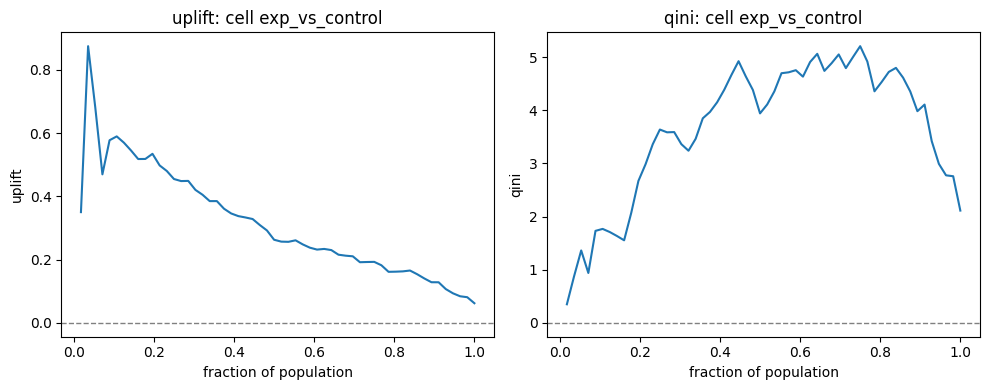

,fraction,uplift,qini,score,level,contrast,y_col
51,0.928571,0.106933,3.421852,-0.147694,cell,exp_vs_control,mn_f_all_idx_fix_z_ad
52,0.946429,0.093550,2.993612,-0.199105,cell,exp_vs_control,mn_f_all_idx_fix_z_ad
53,0.964286,0.084159,2.777260,-0.213632,cell,exp_vs_control,mn_f_all_idx_fix_z_ad
54,0.982143,0.081174,2.759923,-0.245347,cell,exp_vs_control,mn_f_all_idx_fix_z_ad
55,1.000000,0.062163,2.113536,-0.406529,cell,exp_vs_control,mn_f_all_idx_fix_z_ad


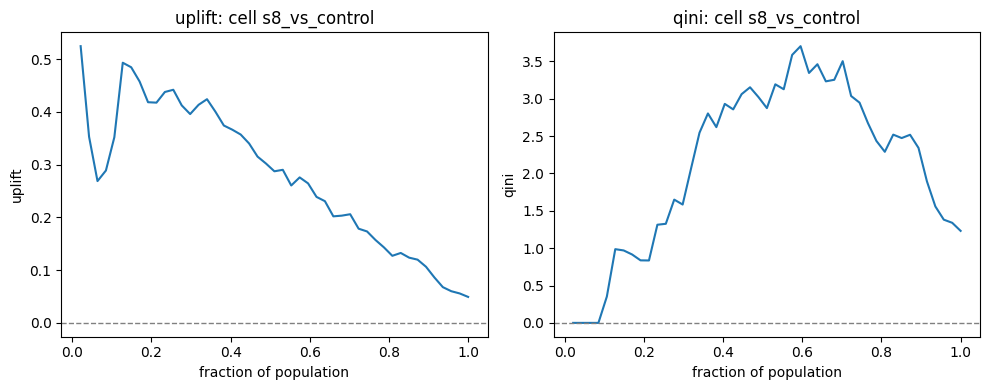

,fraction,uplift,qini,score,level,contrast,y_col
42,0.914894,0.086080,1.893754,-0.147769,cell,s8_vs_control,mn_f_all_idx_fix_z_ad
43,0.936170,0.067755,1.558373,-0.157353,cell,s8_vs_control,mn_f_all_idx_fix_z_ad
44,0.957447,0.060064,1.381465,-0.166939,cell,s8_vs_control,mn_f_all_idx_fix_z_ad
45,0.978723,0.055809,1.339409,-0.185431,cell,s8_vs_control,mn_f_all_idx_fix_z_ad
46,1.000000,0.049246,1.231159,-0.233125,cell,s8_vs_control,mn_f_all_idx_fix_z_ad


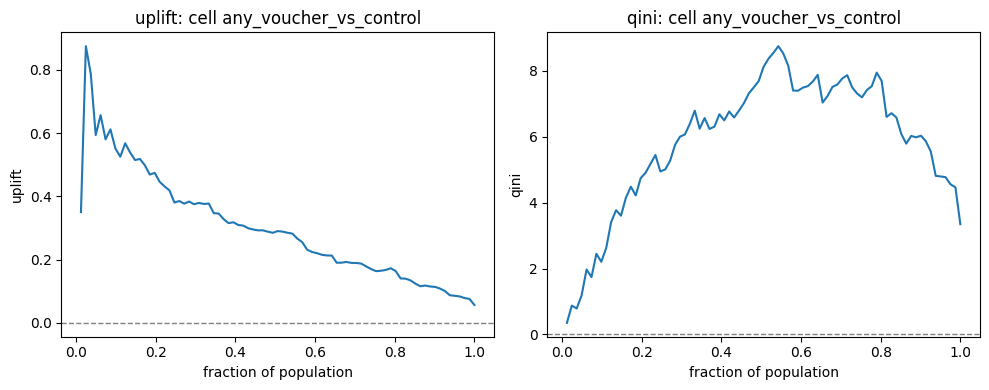

,fraction,uplift,qini,score,level,contrast,y_col
76,0.950617,0.085625,4.795000,-0.243567,cell,any_voucher_vs_control,mn_f_all_idx_fix_z_ad
77,0.962963,0.083719,4.771955,-0.262126,cell,any_voucher_vs_control,mn_f_all_idx_fix_z_ad
78,0.975309,0.078545,4.555603,-0.274939,cell,any_voucher_vs_control,mn_f_all_idx_fix_z_ad
79,0.987654,0.075701,4.466365,-0.341793,cell,any_voucher_vs_control,mn_f_all_idx_fix_z_ad
80,1.000000,0.056690,3.344695,-0.375149,cell,any_voucher_vs_control,mn_f_all_idx_fix_z_ad


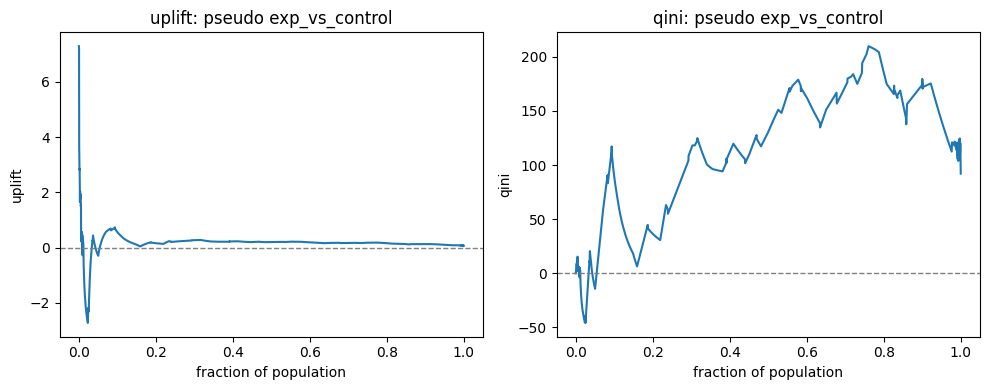

,fraction,uplift,qini,score,level,contrast,y_col
2590,0.998459,0.077368,112.570091,-0.651121,pseudo,exp_vs_control,ps_f_all_idx_fix_z_ad
2591,0.998844,0.082569,120.220551,-0.683292,pseudo,exp_vs_control,ps_f_all_idx_fix_z_ad
2592,0.999229,0.075556,110.009064,-0.683812,pseudo,exp_vs_control,ps_f_all_idx_fix_z_ad
2593,0.999615,0.069490,101.177826,-0.790097,pseudo,exp_vs_control,ps_f_all_idx_fix_z_ad
2594,1.000000,0.063219,92.046883,-0.898423,pseudo,exp_vs_control,ps_f_all_idx_fix_z_ad


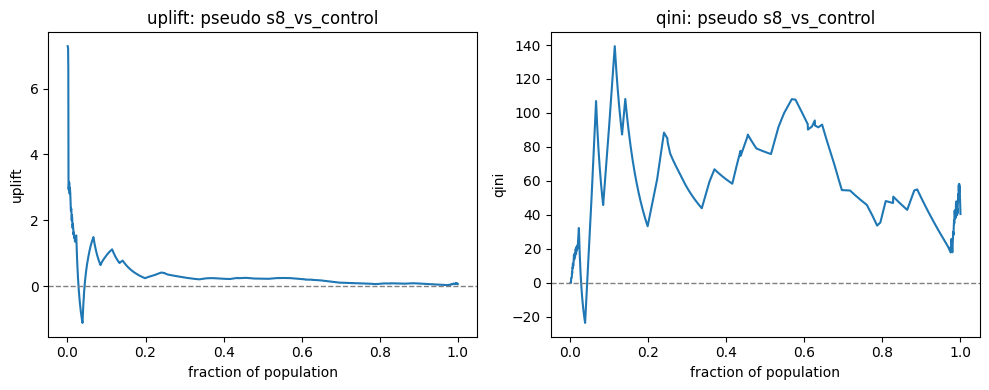

,fraction,uplift,qini,score,level,contrast,y_col
1812,0.997799,0.083902,56.885628,-1.648712,pseudo,s8_vs_control,ps_f_all_idx_fix_z_ad
1813,0.998349,0.078423,53.170685,-1.687935,pseudo,s8_vs_control,ps_f_all_idx_fix_z_ad
1814,0.998899,0.072130,48.903915,-1.774905,pseudo,s8_vs_control,ps_f_all_idx_fix_z_ad
1815,0.999450,0.066064,44.791565,-1.857899,pseudo,s8_vs_control,ps_f_all_idx_fix_z_ad
1816,1.000000,0.059782,40.532516,-1.863825,pseudo,s8_vs_control,ps_f_all_idx_fix_z_ad


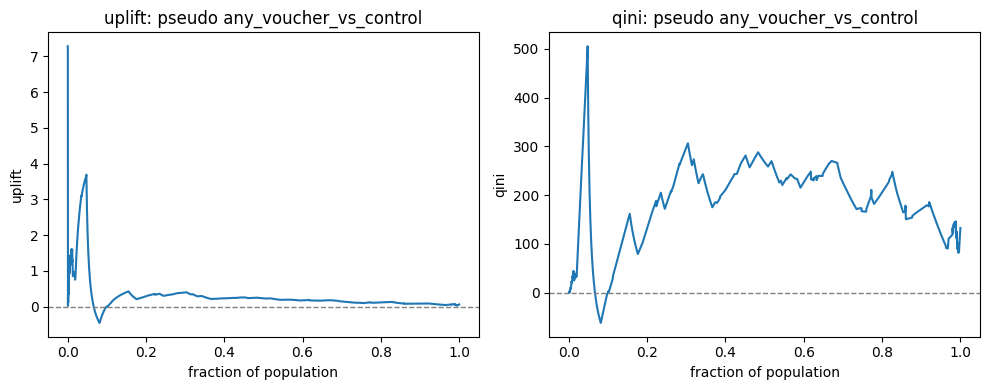

,fraction,uplift,qini,score,level,contrast,y_col
3268,0.998778,0.054956,117.055252,-0.869609,pseudo,any_voucher_vs_control,ps_f_all_idx_fix_z_ad
3269,0.999083,0.057156,121.798416,-0.975883,pseudo,any_voucher_vs_control,ps_f_all_idx_fix_z_ad
3270,0.999389,0.059085,125.970016,-0.999132,pseudo,any_voucher_vs_control,ps_f_all_idx_fix_z_ad
3271,0.999694,0.060262,128.538803,-1.046765,pseudo,any_voucher_vs_control,ps_f_all_idx_fix_z_ad
3272,1.000000,0.062126,132.577835,-1.226501,pseudo,any_voucher_vs_control,ps_f_all_idx_fix_z_ad


In [8]:
# uplift + qini curves for the overall index (cells + pseudo)
examples = [
    ("cell", "mn_f_all_idx_fix_z_ad"),
    ("pseudo", "ps_f_all_idx_fix_z_ad"),
]
for level, y_col in examples:
    for contrast in CONTRASTS:
        key = (level, contrast, y_col)
        if key not in qini_store:
            continue
        curve = qini_store[key]
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        ax[0].plot(curve["fraction"], curve["uplift"])
        ax[0].axhline(0, color="gray", linestyle="--", linewidth=1)
        ax[0].set_title(f"uplift: {level} {contrast}")
        ax[0].set_xlabel("fraction of population")
        ax[0].set_ylabel("uplift")
        ax[1].plot(curve["fraction"], curve["qini"])
        ax[1].axhline(0, color="gray", linestyle="--", linewidth=1)
        ax[1].set_title(f"qini: {level} {contrast}")
        ax[1].set_xlabel("fraction of population")
        ax[1].set_ylabel("qini")
        plt.tight_layout()
        plt.show()
        display(curve.tail())
